# Distributed Full-Field Inference

This notebook demonstrates Bayesian inference of cosmological parameters from full-field convergence maps.

We use a half-sky configuration (observer at (0.5, 0.5, 1.0)) and perform distributed sampling using BlackJAX MCLMC to infer cosmological parameters from synthetic observations.

## Imports

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import compute_box_size_from_redshift
from fwd_model_tools.plotting import plot_ic, plot_kappa, plot_lightcone, plot_posterior
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


JAX devices: 1
JAX backend: gpu


## Configuration Parameters

In [2]:
output_dir = "output_02_distributed"
box_shape = (16, 16, 16)
max_redshift = 0.5
number_of_shells = 8
geometry = "spherical"
observer_position = (0.5, 0.5, 1.0)
num_warmup = 20
num_samples = 10
batch_count = 2
sampler = "MCLMC"
backend = "blackjax"
sigma_e = 0.3
magick_seed = 42

output_dir_path = Path(output_dir)
plots_dir = output_dir_path / "plots"
samples_dir = output_dir_path / "samples"
data_dir = output_dir_path / "data"

plots_dir.mkdir(parents=True, exist_ok=True)
samples_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

fiducial_cosmology = Planck18()
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position)

print(f"Box size: {box_size} Mpc/h")
print(f"Max redshift: {max_redshift}")
print(f"Observer position (half-sky): {observer_position}")

Box size: (2635.3309394476964, 2635.3309394476964, 1317.6654697238482) Mpc/h
Max redshift: 0.5
Observer position (half-sky): (0.5, 0.5, 1.0)


## Setup Sharding and Redshift Distribution

In [3]:
if jax.device_count() > 1:
    from jax.sharding import NamedSharding
    from jax.sharding import PartitionSpec as P

    mesh = jax.make_mesh((4, 2), ("x", "y"))
    sharding = NamedSharding(mesh, P("x", "y"))
    print(f"Using sharding with mesh: (4, 2)")
else:
    sharding = None
    print("Single device mode - no sharding")

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)

Single device mode - no sharding
z_centers = [0.2   0.297 0.393 0.49 ]


## Instantiate Probabilistic Model

In [4]:
config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    number_of_shells=number_of_shells,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.24, 0.28),
        "sigma8": dist.Uniform(0.78, 0.82),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=True,
    log_ic=True,
)

print("Configuration created")

initial_conditions = normal_field(jax.random.key(magick_seed), config.box_shape, sharding=sharding)
print("Initial conditions generated")

Configuration created


Initial conditions generated


## Trace Model to Generate Synthetic Observations

In [5]:
print("Generating synthetic observations")

full_field_basemodel = full_field_probmodel(config)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model to generate observables...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"Fiducial model traced in {elapsed:.2f}s")

kappa_keys = [f"kappa_{i}" for i in range(nbins)]
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

if config.geometry == "spherical":
    true_kappas_full = reconstruct_full_kappa(
        true_kappas_visible, config.nside, config.observer_position
    )
else:
    true_kappas_full = true_kappas_visible

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)

true_ic = np.asarray(model_trace["ic"]["value"])
np.save(data_dir / "true_ic.npy", true_ic)

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)

print("Saved observations to disk")

Generating synthetic observations


Tracing fiducial model to generate observables...


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


Fiducial model traced in 7.63s


Saved observations to disk


## Plot Lightcone

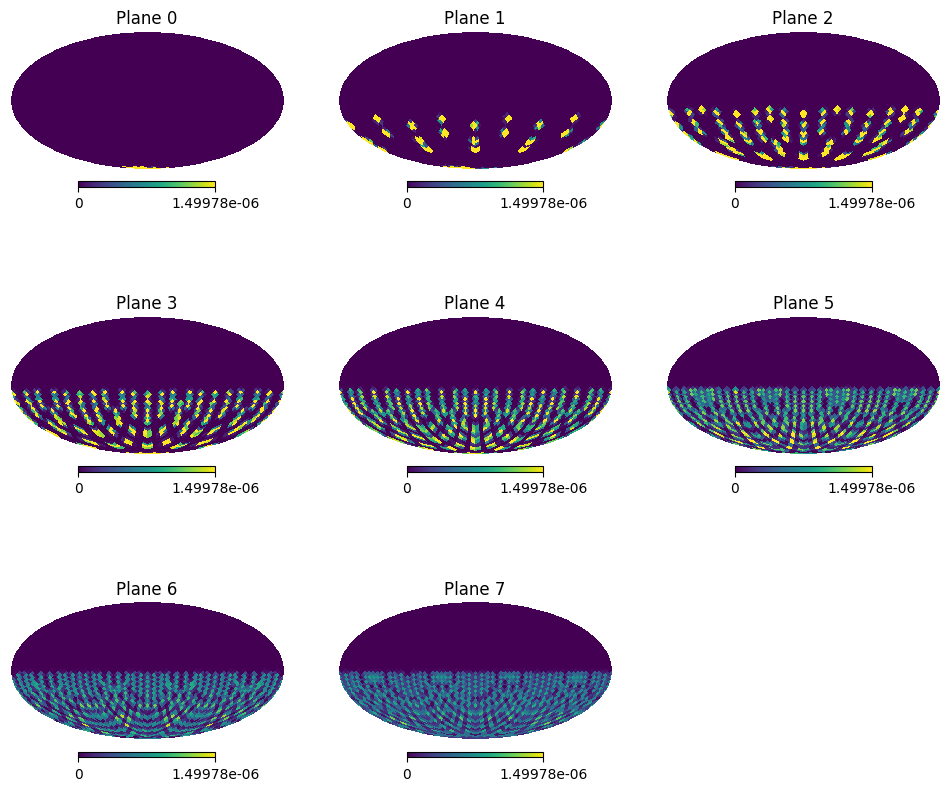

Plotted lightcone


In [6]:
plot_lightcone(true_lightcone, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print("Plotted lightcone")

## Plot Kappa Maps

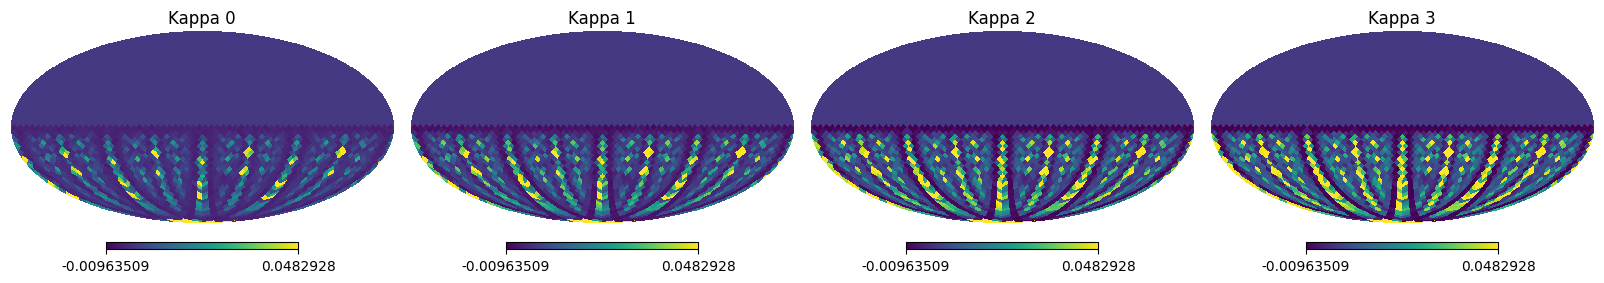

Plotted kappa maps


In [7]:
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print("Plotted kappa maps")

## Condition Model on Observations

In [8]:
print("Setting up MCMC inference")

config_inference = config._replace(log_lightcone=False, log_ic=True)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_visible[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}
init_params = jax.tree.map(jnp.asarray, init_params)

print(f"Sampling with {sampler} using {backend} backend")
print(f"Warmup: {num_warmup}, Samples: {num_samples}, Batches: {batch_count}")

Setting up MCMC inference
Sampling with MCLMC using blackjax backend
Warmup: 20, Samples: 10, Batches: 2


## Run Distributed Inference

In [9]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params,
    progress_bar=True,
)

print("MCMC sampling completed")

üîÅ Starting fresh with warmup for MCLMC using blackjax...


üîß Tuning MCLMC parameters (L and step_size)...


üì¶ Sampling batch 1/2 using MCLMC with blackjax...

at sample batch 1, total samples: 0




üíæ Saving batch 1 samples and state...
üì¶ Sampling batch 2/2 using MCLMC with blackjax...

at sample batch 2, total samples: 10




üíæ Saving batch 2 samples and state...
MCMC sampling completed


## Load Samples and Analyze Results

In [10]:
print("Loading samples and analyzing results")

samples = load_samples(str(samples_dir))
print(f"Loaded {len(samples['Omega_c'])} samples")
print(f"Parameters: {list(samples.keys())}")

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

print("\nPosterior Statistics:")
print(f"True Omega_c: {true_Omega_c:.4f}")
print(f"Inferred Omega_c: {samples['Omega_c'].mean():.4f} ¬± {samples['Omega_c'].std():.4f}")
print(f"True sigma8: {true_sigma8:.4f}")
print(f"Inferred sigma8: {samples['sigma8'].mean():.4f} ¬± {samples['sigma8'].std():.4f}")

Loading samples and analyzing results
Loading 2 sample batch(es) from output_02_distributed/samples
  Loading batch 1/2: samples_0
  Loading batch 2/2: samples_1
Loaded 5 parameter(s): ['sigma8', 'num_steps', 'Omega_c', 'initial_conditions', 'ic']
Total samples: 20
Loaded 20 samples
Parameters: ['sigma8', 'num_steps', 'Omega_c', 'initial_conditions', 'ic']

Posterior Statistics:
True Omega_c: 0.2607


Inferred Omega_c: 0.2680 ¬± 0.0001
True sigma8: 0.8102
Inferred sigma8: 0.8077 ¬± 0.0000


/home/wassim/micromamba/envs/ffi12/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Plot Initial Conditions Comparison

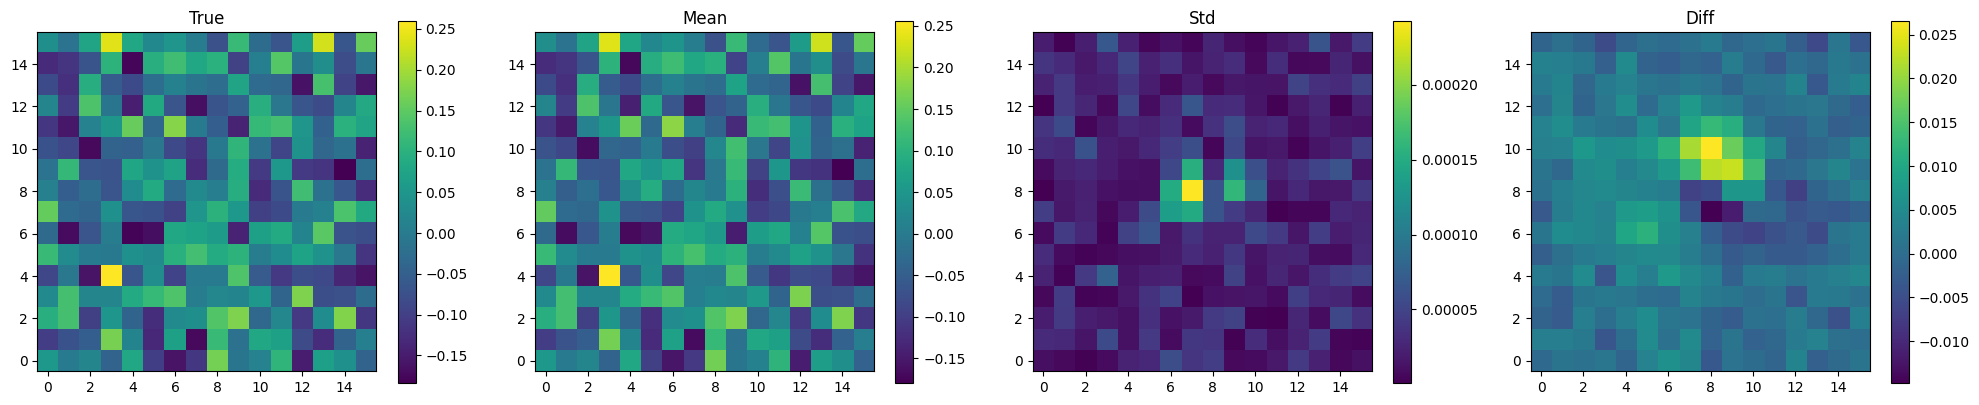

Plotted IC comparison


In [11]:
if "ic" in samples:
    true_ic = np.load(data_dir / "true_ic.npy")
    plot_ic(
        true_ic,
        samples["ic"],
        plots_dir,
        titles=("True", "Mean", "Std", "Diff"),
        output_format="show",
    )
    print("Plotted IC comparison")

## Plot Posterior (GetDist 3-panel)

Removed no burn in


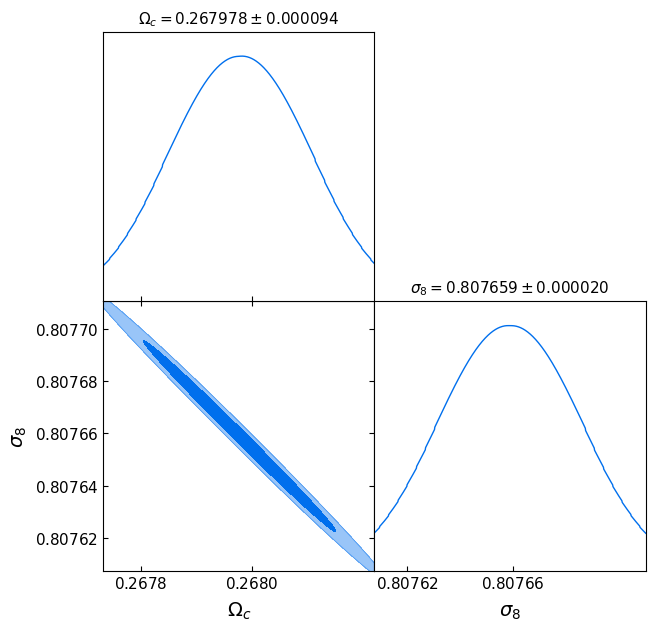

Plotted posteriors


In [12]:
param_samples = {"Omega_c": samples["Omega_c"], "sigma8": samples["sigma8"]}
true_param_values = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}

labels = {"Omega_c": r"\Omega_c", "sigma8": r"\sigma_8"}

plot_posterior(
    param_samples,
    plots_dir,
    params=("Omega_c", "sigma8"),
    true_values=true_param_values,
    labels=labels,
    output_format="show",
    filled=True,
    title_limit=1,
    width_inch=7,
)
print("Plotted posteriors")